<a href="https://colab.research.google.com/github/b1becker/love_to_hate_sentiment_analysis/blob/main/kyrie_irving_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install praw pandas numpy textblob vaderSentiment matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 12.0 MB/s eta 0:00:00


In [4]:
import praw
import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

class RedditKyrieIrvingSentimentAnalyzer:
    def __init__(self):
        """Initialize the Reddit-only sentiment analyzer for Kyrie Irving"""
        self.reddit = None
        self.vader_analyzer = SentimentIntensityAnalyzer()
        self.posts_data = []

    def setup_reddit_api(self, client_id: str, client_secret: str, user_agent: str):
        """
        Setup Reddit API - FREE with registration

        Steps to get FREE Reddit API access:
        1. Go to https://www.reddit.com/prefs/apps
        2. Click "Create App" or "Create Another App"
        3. Fill out the form:
           - Name: KyrieIrvingSentiment
           - App type: Select "script"
           - Description: Sentiment analysis of Kyrie Irving posts
           - About URL: (leave blank)
           - Redirect URI: http://localhost:8080
        4. Click "Create app"
        5. Copy the client_id (random string under app name) and client_secret

        Rate Limits: 60 requests per minute, 600 per hour - completely FREE
        """
        try:
            self.reddit = praw.Reddit(
                client_id=client_id,
                client_secret=client_secret,
                user_agent=user_agent
            )
            # Test the connection
            print(f"✅ Reddit API connected successfully!")
            try:
                user = self.reddit.user.me()
                print(f"✅ Authenticated as: {user}")
            except:
                print("✅ Connected in read-only mode (perfect for scraping)")
            return True
        except Exception as e:
            print(f"❌ Reddit API setup failed: {e}")
            print("💡 Double-check your client_id and client_secret")
            return False

    def scrape_kyrie_irving_posts(self, limit: int = 1000, days_back: int = 1825):  # 5 years = ~1825 days
        """
        Scrape real Kyrie Irving posts from Reddit

        Args:
            limit: Maximum number of posts to scrape
            days_back: How many days back to search (default 1825 = 5 years)
        """
        if not self.reddit:
            print("❌ Reddit API not configured. Call setup_reddit_api() first.")
            return []

        print(f"🔍 Scraping {limit} Kyrie Irving posts from the last {days_back} days...")

        # Subreddits to search (NBA/basketball-focused)
        subreddits = [
            'nba',                  # Main NBA subreddit
            'basketball',           # General basketball
            'nbadiscussion',        # NBA discussion
            'BostonCeltics',        # Former team
            'clevelandcavs',        # Former team (won championship)
            'GoNets',               # Former team
            'Mavericks',            # Current team
            'fantasybball',         # Fantasy basketball
            'lakers',               # Popular team
            'warriors',             # Popular team
            'heat',                 # Popular team
            'sixers',               # Popular team
            'chicagobulls',         # Popular team
            'NYKnicks',             # New York team
            'torontoraptors',       # Canadian team
            'memphisgrizzlies',     # Western conference
            'suns',                 # Western conference
            'kings',                # Western conference
            'nbamemes',             # NBA memes
            'ripcity',              # Portland
            'Thunder',              # OKC
            'denvernuggets',        # Western conference
            'timberwolves',         # Western conference
            'nbaww'                 # NBA wholesome content
        ]

        # Search terms for Kyrie Irving content
        search_terms = [
            'Kyrie Irving',
            'Kyrie',
            'Irving',
            '#KyrieIrving',
            'Uncle Drew',           # Common nickname
            'Kai',                  # Another nickname
            'Kyrie Mavs',
            'Kyrie Dallas'
        ]

        posts_data = []
        posts_per_sub = max(1, limit // len(subreddits))

        for subreddit_name in subreddits:
            try:
                subreddit = self.reddit.subreddit(subreddit_name)
                print(f"📡 Searching r/{subreddit_name}...")

                # Try multiple search approaches
                posts_found = 0

                # 1. Search for each term
                for term in search_terms:
                    try:
                        for submission in subreddit.search(
                            term,
                            sort='new',
                            time_filter='all',  # Search all time for 5-year history
                            limit=posts_per_sub // len(search_terms)
                        ):
                            # Check if post is within our date range (5 years)
                            post_date = datetime.fromtimestamp(submission.created_utc)
                            if post_date < datetime.now() - timedelta(days=days_back):
                                continue

                            # Skip if we already have this post
                            if any(p['id'] == submission.id for p in posts_data):
                                continue

                            # Get post data
                            post_data = self.extract_post_data(submission, subreddit_name)
                            if post_data:
                                posts_data.append(post_data)
                                posts_found += 1

                            # Rate limiting - be nice to Reddit
                            time.sleep(0.1)

                            if len(posts_data) >= limit:
                                break

                        if len(posts_data) >= limit:
                            break

                    except Exception as e:
                        print(f"⚠️ Search error for '{term}' in r/{subreddit_name}: {e}")
                        continue

                print(f"  📊 Found {posts_found} posts in r/{subreddit_name}")

            except Exception as e:
                print(f"⚠️ Error accessing r/{subreddit_name}: {e}")
                continue

            if len(posts_data) >= limit:
                print(f"✅ Reached target of {limit} posts!")
                break

        print(f"✅ Total scraped: {len(posts_data)} posts successfully!")
        self.posts_data = posts_data
        return posts_data

    def extract_post_data(self, submission, subreddit_name: str) -> Dict:
        """Extract comprehensive data from a Reddit submission"""
        try:
            post_data = {
                'id': submission.id,
                'title': submission.title,
                'selftext': submission.selftext or '',
                'score': submission.score,
                'upvote_ratio': submission.upvote_ratio,
                'num_comments': submission.num_comments,
                'created_utc': datetime.fromtimestamp(submission.created_utc),
                'subreddit': subreddit_name,
                'url': submission.url,
                'author': str(submission.author) if submission.author else '[deleted]',
                'is_self': submission.is_self,
                'permalink': f"https://reddit.com{submission.permalink}",
                'gilded': submission.gilded,
                'distinguished': submission.distinguished,
                'stickied': submission.stickied
            }

            # Get top comments for additional context
            try:
                submission.comments.replace_more(limit=0)
                top_comments = []
                comment_count = 0

                for comment in submission.comments:
                    if comment_count >= 15:  # Limit to top 15 comments for basketball discussions
                        break

                    if hasattr(comment, 'body') and comment.body not in ['[deleted]', '[removed]']:
                        comment_data = {
                            'body': comment.body,
                            'score': comment.score,
                            'created_utc': datetime.fromtimestamp(comment.created_utc),
                            'author': str(comment.author) if comment.author else '[deleted]'
                        }
                        top_comments.append(comment_data)
                        comment_count += 1

                post_data['top_comments'] = top_comments
                post_data['comments_analyzed'] = len(top_comments)

            except Exception as e:
                print(f"⚠️ Error getting comments for post {submission.id}: {e}")
                post_data['top_comments'] = []
                post_data['comments_analyzed'] = 0

            return post_data

        except Exception as e:
            print(f"⚠️ Error extracting post data: {e}")
            return None

    def analyze_sentiment_comprehensive(self, text: str) -> Dict:
        """
        Comprehensive sentiment analysis using multiple methods
        Uses only offline methods - no external API calls needed
        """
        # Clean the text
        text = text.replace('\n', ' ').replace('\r', ' ')
        text = ' '.join(text.split())  # Remove extra whitespace

        results = {}

        # 1. TextBlob Analysis
        try:
            blob = TextBlob(text)
            results['textblob_polarity'] = blob.sentiment.polarity  # -1 to 1
            results['textblob_subjectivity'] = blob.sentiment.subjectivity  # 0 to 1
        except Exception as e:
            print(f"TextBlob error: {e}")
            results['textblob_polarity'] = 0
            results['textblob_subjectivity'] = 0.5

        # 2. VADER Analysis
        try:
            vader_scores = self.vader_analyzer.polarity_scores(text)
            results['vader_compound'] = vader_scores['compound']  # -1 to 1
            results['vader_positive'] = vader_scores['pos']
            results['vader_negative'] = vader_scores['neg']
            results['vader_neutral'] = vader_scores['neu']
        except Exception as e:
            print(f"VADER error: {e}")
            results.update({
                'vader_compound': 0,
                'vader_positive': 0,
                'vader_negative': 0,
                'vader_neutral': 1
            })

        # 3. Calculate composite negativity score
        negativity_components = []

        # From TextBlob (convert polarity to negativity)
        if results['textblob_polarity'] < 0:
            negativity_components.append(abs(results['textblob_polarity']))

        # From VADER
        negativity_components.append(results['vader_negative'])

        # Average negativity
        results['negativity_score'] = np.mean(negativity_components) if negativity_components else 0

        return results

    def extract_kyrie_mentions(self, text: str) -> str:
        """Extract only sentences/phrases that mention Kyrie"""
        import re

        # Kyrie-related terms
        kyrie_terms = [
            'kyrie', 'irving', 'uncle drew', 'kai',
            'kyrie irving', 'mavs kyrie', 'dallas kyrie'
        ]

        sentences = text.split('.')
        kyrie_sentences = []

        for sentence in sentences:
            if any(term.lower() in sentence.lower() for term in kyrie_terms):
                kyrie_sentences.append(sentence.strip())

        return ' '.join(kyrie_sentences)

    def analyze_kyrie_specific_sentiment(self, text: str) -> Dict:
        """Analyze sentiment only for Kyrie-related content"""

        # Extract only Kyrie-related text
        kyrie_text = self.extract_kyrie_mentions(text)

        if not kyrie_text or len(kyrie_text.strip()) < 10:
            # Not enough Kyrie-specific content
            return {
                'kyrie_specific': False,
                'textblob_polarity': 0,
                'textblob_subjectivity': 0.5,
                'vader_compound': 0,
                'vader_positive': 0,
                'vader_negative': 0,
                'vader_neutral': 1,
                'negativity_score': 0,
                'kyrie_text_length': 0
            }

        # Run sentiment analysis only on Kyrie-specific text
        results = self.analyze_sentiment_comprehensive(kyrie_text)
        results['kyrie_specific'] = True
        results['kyrie_text_length'] = len(kyrie_text)

        return results

    def process_all_posts_sentiment(self):
        """Process sentiment analysis for all scraped posts"""
        if not self.posts_data:
            print("❌ No posts data available. Run scrape_kyrie_irving_posts() first.")
            return []

        print(f"🧠 Analyzing Kyrie-specific sentiment for {len(self.posts_data)} posts...")

        processed_posts = []

        for i, post in enumerate(self.posts_data):
            # Combine all text for analysis
            full_text = f"{post['title']} {post['selftext']}"

            # Add top comments to analysis
            if post['top_comments']:
                comments_text = " ".join([comment['body'] for comment in post['top_comments']])
                full_text += f" {comments_text}"

            # Analyze sentiment ONLY for Kyrie-specific content
            sentiment_results = self.analyze_kyrie_specific_sentiment(full_text)

            # Combine with post metadata
            post_analysis = {
                **post,  # All original post data
                **sentiment_results,  # All sentiment scores
                'full_text_length': len(full_text),
                'analysis_date': datetime.now()
            }

            # Mark if post exceeds negativity threshold for hate index calculation
            post_analysis['is_negative'] = sentiment_results['negativity_score'] > 0.075 if sentiment_results['kyrie_specific'] else False

            processed_posts.append(post_analysis)

            # Progress indicator
            if (i + 1) % 25 == 0:
                kyrie_specific_count = sum(1 for p in processed_posts if p.get('kyrie_specific', False))
                print(f"📊 Processed {i + 1}/{len(self.posts_data)} posts... ({kyrie_specific_count} Kyrie-specific)")

        # Filter to only posts with Kyrie-specific content for final results
        kyrie_posts = [post for post in processed_posts if post.get('kyrie_specific', False)]

        # Calculate overall hate index as percentage of posts over 0.09 negativity
        if kyrie_posts:
            negative_posts = sum(1 for post in kyrie_posts if post.get('is_negative', False))
            hate_index_percentage = (negative_posts / len(kyrie_posts)) * 100

            # Add hate index percentage to each post for dashboard
            for post in kyrie_posts:
                post['hate_index'] = hate_index_percentage
        else:
            hate_index_percentage = 0

        print(f"✅ Sentiment analysis complete!")
        print(f"📈 Found {len(kyrie_posts)} posts with Kyrie-specific content out of {len(processed_posts)} total")
        print(f"🔥 Hate Index: {hate_index_percentage:.1f}% of posts have negativity > 0.075")

        return kyrie_posts

    def create_comprehensive_dashboard(self, sentiment_data: List[Dict]):
        """Create a comprehensive dashboard with multiple visualizations"""
        df = pd.DataFrame(sentiment_data)

        # Create the main figure
        fig = plt.figure(figsize=(20, 14))
        gs = fig.add_gridspec(5, 4, height_ratios=[0.4, 1, 1, 1, 1])

        # Main title
        fig.suptitle('🏀 KYRIE IRVING REDDIT SENTIMENT ANALYSIS DASHBOARD 🏀',
                    fontsize=24, fontweight='bold', color='darkred', y=0.97)

        # Calculate key metrics
        avg_negativity = df['negativity_score'].mean()
        max_negativity = df['negativity_score'].max()
        total_posts = len(df)
        avg_reddit_score = df['score'].mean()
        total_comments = df['num_comments'].sum()
        date_range = f"{df['created_utc'].min().strftime('%Y-%m-%d')} to {df['created_utc'].max().strftime('%Y-%m-%d')}"

        # Calculate hate index as percentage of posts over 0.09 negativity
        negative_posts = len(df[df['negativity_score'] > 0.09])
        hate_index_percentage = (negative_posts / total_posts) * 100 if total_posts > 0 else 0

        # Top metrics row
        ax_metrics = fig.add_subplot(gs[0, :])
        metrics_text = f"""
        📊 POSTS: {total_posts:,} | 📅 PERIOD: {date_range} | 🔴 AVG NEGATIVITY: {avg_negativity:.3f} |
        ⚡ PEAK NEGATIVITY: {max_negativity:.3f} | 🔥 HATE INDEX: {hate_index_percentage:.1f}% | 📈 AVG SCORE: {avg_reddit_score:.1f} | 🗣️ COMMENTS: {total_comments:,}
        """
        ax_metrics.text(0.5, 0.5, metrics_text, ha='center', va='center',
                       fontsize=14, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
        ax_metrics.axis('off')

        # 1. Sentiment over time
        ax_timeline = fig.add_subplot(gs[1, :2])
        df_sorted = df.sort_values('created_utc')
        ax_timeline.scatter(df_sorted['created_utc'], df_sorted['negativity_score'],
                           c=df_sorted['score'], cmap='RdYlGn', alpha=0.6, s=30)
        ax_timeline.plot(df_sorted['created_utc'], df_sorted['negativity_score'].rolling(10).mean(),
                        color='red', linewidth=2, label='10-post moving average')
        ax_timeline.set_title('Negativity Timeline (5-Year Period)', fontsize=14, fontweight='bold')
        ax_timeline.set_ylabel('Negativity Score')
        ax_timeline.legend()
        ax_timeline.grid(True, alpha=0.3)

        # 2. Subreddit comparison
        ax_subreddit = fig.add_subplot(gs[1, 2:])
        subreddit_stats = df.groupby('subreddit').agg({
            'negativity_score': 'mean',
            'score': 'mean',
            'id': 'count'
        }).round(3)
        subreddit_stats = subreddit_stats.sort_values('negativity_score', ascending=False)

        bars = ax_subreddit.barh(range(len(subreddit_stats)), subreddit_stats['negativity_score'],
                                color='red', alpha=0.7)
        ax_subreddit.set_yticks(range(len(subreddit_stats)))
        ax_subreddit.set_yticklabels([f"r/{sub} ({subreddit_stats.loc[sub, 'id']} posts)"
                                     for sub in subreddit_stats.index])
        ax_subreddit.set_title('Average Negativity by Subreddit', fontsize=14, fontweight='bold')
        ax_subreddit.set_xlabel('Negativity Score')

        # 3. Most negative posts table
        most_negative = df.nlargest(15, 'negativity_score')
        ax_table = fig.add_subplot(gs[2:4, :2])
        ax_table.axis('off')
        ax_table.set_title('🔥 TOP 15 MOST NEGATIVE KYRIE POSTS 🔥',
                          fontsize=16, fontweight='bold', color='red', pad=20)

        # Create table data
        table_data = []
        for i, (_, row) in enumerate(most_negative.iterrows(), 1):
            title_short = row['title'][:50] + "..." if len(row['title']) > 50 else row['title']
            negativity_value = f"{row['negativity_score']:.3f}"
            is_above_threshold = "🔥" if row['negativity_score'] > 0.09 else "💤"
            table_data.append([
                f"{i}",
                title_short,
                negativity_value,
                is_above_threshold,
                f"{row['score']:.0f}",
                f"r/{row['subreddit']}",
                row['created_utc'].strftime('%m/%d/%y')
            ])

        col_labels = ['#', 'Post Title', 'Negativity', '🔥', 'Score', 'Sub', 'Date']
        col_widths = [0.05, 0.5, 0.1, 0.05, 0.1, 0.15, 0.05]

        table = ax_table.table(cellText=table_data,
                              colLabels=col_labels,
                              cellLoc='left',
                              loc='center',
                              colWidths=col_widths)

        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 1.2)

        # Color code table rows based on negativity score
        for i in range(len(table_data)):
            negativity_value = float(table_data[i][2])
            if negativity_value > 0.09:
                color = '#FF4444'  # Red for above threshold
                text_color = 'white'
            elif negativity_value > 0.05:
                color = '#FF8888'  # Light red
                text_color = 'black'
            else:
                color = '#FFCCCC'  # Very light red
                text_color = 'black'

            for j in range(len(col_labels)):
                table[(i+1, j)].set_facecolor(color)
                table[(i+1, j)].set_text_props(color=text_color)

        # 4. Sentiment distribution
        ax_dist = fig.add_subplot(gs[2, 2:])
        ax_dist.hist(df['negativity_score'], bins=25, alpha=0.7, color='red', edgecolor='black')
        ax_dist.axvline(avg_negativity, color='blue', linestyle='--', linewidth=2,
                       label=f'Average: {avg_negativity:.3f}')
        ax_dist.set_title('Negativity Score Distribution', fontsize=14, fontweight='bold')
        ax_dist.set_xlabel('Negativity Score')
        ax_dist.set_ylabel('Number of Posts')
        ax_dist.legend()
        ax_dist.grid(True, alpha=0.3)

        # 5. Controversy analysis
        ax_controversy = fig.add_subplot(gs[3, 2:])
        scatter = ax_controversy.scatter(df['score'], df['num_comments'],
                                        c=df['negativity_score'], cmap='Reds',
                                        s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
        ax_controversy.set_title('Controversy Analysis\n(Reddit Score vs Comments)', fontsize=14, fontweight='bold')
        ax_controversy.set_xlabel('Reddit Score')
        ax_controversy.set_ylabel('Number of Comments')
        ax_controversy.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax_controversy, label='Negativity Score')

        # 6. VADER Analysis Summary
        ax_methods = fig.add_subplot(gs[4, :])

        # VADER category breakdown
        vader_categories = {
            'Extremely Negative\n(≤ -0.6)': len(df[df['vader_compound'] <= -0.6]),
            'Negative\n(-0.6 to -0.2)': len(df[(df['vader_compound'] > -0.6) & (df['vader_compound'] <= -0.2)]),
            'Slightly Negative\n(-0.2 to -0.05)': len(df[(df['vader_compound'] > -0.2) & (df['vader_compound'] <= -0.05)]),
            'Neutral\n(-0.05 to 0.05)': len(df[(df['vader_compound'] > -0.05) & (df['vader_compound'] <= 0.05)]),
            'Positive\n(> 0.05)': len(df[df['vader_compound'] > 0.05])
        }

        categories = list(vader_categories.keys())
        counts = list(vader_categories.values())
        colors = ['darkred', 'red', 'orange', 'gray', 'lightgreen']

        bars = ax_methods.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black')

        # Add percentage labels on bars
        total_posts = len(df)
        for bar, count in zip(bars, counts):
            percentage = (count / total_posts) * 100
            height = bar.get_height()
            ax_methods.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{count}\n({percentage:.1f}%)', ha='center', va='bottom',
                           fontweight='bold', fontsize=10)

        ax_methods.set_title('VADER Sentiment Category Breakdown', fontsize=16, fontweight='bold')
        ax_methods.set_ylabel('Number of Posts')
        ax_methods.grid(True, alpha=0.3, axis='y')

        # Add summary text with new hate index definition
        negative_total = vader_categories['Extremely Negative\n(≤ -0.6)'] + vader_categories['Negative\n(-0.6 to -0.2)']
        negative_percentage = (negative_total / total_posts) * 100

        summary_text = f"🔥 HATE INDEX: {hate_index_percentage:.1f}% of posts have negativity > 0.09 threshold"
        ax_methods.text(0.5, 0.95, summary_text, transform=ax_methods.transAxes,
                       ha='center', va='top', fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.8))

        plt.tight_layout()
        plt.subplots_adjust(top=0.94)
        return fig

    def generate_detailed_report(self, sentiment_data: List[Dict]) -> str:
        """Generate a comprehensive text report"""
        df = pd.DataFrame(sentiment_data)

        report = "🏀 KYRIE IRVING REDDIT SENTIMENT ANALYSIS REPORT 🏀\n"
        report += "=" * 70 + "\n\n"

        # Summary statistics
        report += "📊 SUMMARY STATISTICS:\n"
        report += f"Total posts analyzed: {len(df):,}\n"
        report += f"Date range: {df['created_utc'].min().strftime('%Y-%m-%d')} to {df['created_utc'].max().strftime('%Y-%m-%d')}\n"
        report += f"Average negativity score: {df['negativity_score'].mean():.3f}\n"
        report += f"Maximum negativity score: {df['negativity_score'].max():.3f}\n"

        # Calculate hate index as percentage
        negative_posts = len(df[df['negativity_score'] > 0.09])
        hate_index_percentage = (negative_posts / len(df)) * 100 if len(df) > 0 else 0
        report += f"Hate Index: {hate_index_percentage:.1f}% (posts with negativity > 0.09)\n"

        report += f"Average Reddit score: {df['score'].mean():.1f}\n"
        report += f"Total comments analyzed: {df['num_comments'].sum():,}\n"
        report += f"Subreddits covered: {df['subreddit'].nunique()}\n\n"

        # Subreddit breakdown
        report += "📈 SUBREDDIT BREAKDOWN:\n"
        subreddit_summary = df.groupby('subreddit').agg({
            'negativity_score': ['mean', 'max', 'count'],
            'score': 'mean'
        }).round(3)

        for subreddit in subreddit_summary.index:
            neg_mean = subreddit_summary.loc[subreddit, ('negativity_score', 'mean')]
            neg_max = subreddit_summary.loc[subreddit, ('negativity_score', 'max')]
            count = subreddit_summary.loc[subreddit, ('negativity_score', 'count')]
            score_mean = subreddit_summary.loc[subreddit, ('score', 'mean')]

            report += f"r/{subreddit}: {count} posts, avg negativity: {neg_mean:.3f}, avg score: {score_mean:.1f}\n"

        report += "\n"

        # Top 25 most negative posts
        report += "🔥 TOP 25 MOST NEGATIVE KYRIE POSTS:\n"
        report += "-" * 50 + "\n"

        most_negative = df.nlargest(25, 'negativity_score')
        for i, (_, row) in enumerate(most_negative.iterrows(), 1):
            above_threshold = "🔥 ABOVE THRESHOLD" if row['negativity_score'] > 0.09 else ""
            report += f"\n#{i} - NEGATIVITY SCORE: {row['negativity_score']:.3f} {above_threshold}\n"
            report += f"Title: {row['title']}\n"
            report += f"Subreddit: r/{row['subreddit']}\n"
            report += f"Reddit Score: {row['score']:.0f} | Comments: {row['num_comments']}\n"
            report += f"Upvote Ratio: {row['upvote_ratio']:.2f}\n"
            report += f"Date: {row['created_utc'].strftime('%Y-%m-%d %H:%M')}\n"
            report += f"Negativity Score: {row['negativity_score']:.3f}\n"
            report += f"Link: {row['permalink']}\n"

            # Add snippet of text
            full_text = f"{row['title']} {row['selftext']}"
            if len(full_text) > 150:
                full_text = full_text[:150] + "..."
            report += f"Preview: {full_text}\n"
            report += "-" * 40 + "\n"

        return report

    def save_comprehensive_results(self, sentiment_data: List[Dict], filename_base: str = 'kyrie_irving_reddit_sentiment'):
        """Save all results to multiple files"""
        df = pd.DataFrame(sentiment_data)

        # Save detailed CSV with all data
        csv_filename = f'{filename_base}_detailed.csv'
        df.to_csv(csv_filename, index=False)
        print(f"✅ Detailed data saved to: {csv_filename}")

        # Save summary CSV with key metrics only
        summary_df = df[['title', 'subreddit', 'score', 'num_comments', 'created_utc',
                        'negativity_score', 'hate_index', 'permalink']].copy()
        summary_filename = f'{filename_base}_summary.csv'
        summary_df.to_csv(summary_filename, index=False)
        print(f"✅ Summary data saved to: {summary_filename}")

        # Save comprehensive text report
        report = self.generate_detailed_report(sentiment_data)
        report_filename = f'{filename_base}_report.txt'
        with open(report_filename, 'w', encoding='utf-8') as f:
            f.write(report)
        print(f"✅ Detailed report saved to: {report_filename}")

        # Save top controversial posts as separate file for easy sharing
        most_controversial = df.nlargest(50, 'hate_index')[['title', 'subreddit', 'hate_index', 'score', 'permalink']]
        controversial_filename = f'{filename_base}_top_controversial.csv'
        most_controversial.to_csv(controversial_filename, index=False)
        print(f"✅ Top controversial posts saved to: {controversial_filename}")

def run_kyrie_irving_analysis():
    """Main function to run the complete Kyrie Irving sentiment analysis"""
    print("🚀 KYRIE IRVING REDDIT SENTIMENT ANALYZER")
    print("=" * 50)
    print("This tool analyzes real Reddit posts about Kyrie Irving")
    print("using only the Reddit API and offline sentiment analysis.\n")

    # Initialize analyzer
    analyzer = RedditKyrieIrvingSentimentAnalyzer()

    # Get Reddit credentials from secrets or user input
    client_id = None
    client_secret = None

    # Try to get from different secret systems
    try:
        # Google Colab
        from google.colab import userdata
        client_id = userdata.get('REDDIT_CLIENT_ID')
        client_secret = userdata.get('REDDIT_CLIENT_SECRET')
        print("✅ Using credentials from Google Colab secrets")
    except:
        try:
            # Kaggle
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            client_id = user_secrets.get_secret("REDDIT_CLIENT_ID")
            client_secret = user_secrets.get_secret("REDDIT_CLIENT_SECRET")
            print("✅ Using credentials from Kaggle secrets")
        except:
            try:
                # Environment variables (local/cloud)
                import os
                client_id = os.environ.get('REDDIT_CLIENT_ID')
                client_secret = os.environ.get('REDDIT_CLIENT_SECRET')
                if client_id and client_secret:
                    print("✅ Using credentials from environment variables")
            except:
                pass

    # If no secrets found, ask user for input
    if not client_id or not client_secret:
        print("📱 REDDIT API SETUP:")
        print("Get your FREE credentials at: https://www.reddit.com/prefs/apps")
        print("Create a 'script' type app and get your client_id and client_secret\n")

        client_id = input("Enter your Reddit client_id: ").strip()
        if not client_id:
            print("❌ Client ID is required. Please get it from Reddit API.")
            return

        client_secret = input("Enter your Reddit client_secret: ").strip()
        if not client_secret:
            print("❌ Client secret is required. Please get it from Reddit API.")
            return

    user_agent = "KyrieIrvingSentiment/1.0"

    # Setup Reddit API
    if not analyzer.setup_reddit_api(client_id, client_secret, user_agent):
        print("❌ Failed to setup Reddit API. Please check your credentials.")
        return

    # Get user preferences
    print("\n⚙️ ANALYSIS SETTINGS:")
    try:
        num_posts = int(input("How many posts to analyze? (default 500): ") or "500")
        days_back = int(input("How many days back to search? (default 1825 for 5 years): ") or "1825")
    except ValueError:
        num_posts = 500
        days_back = 1825
        print("Using default settings: 500 posts, 1825 days (5 years)")

    # Start analysis
    print(f"\n🔍 Starting analysis of {num_posts} posts from last {days_back} days...")

    # Step 1: Scrape posts
    posts = analyzer.scrape_kyrie_irving_posts(limit=num_posts, days_back=days_back)
    if not posts:
        print("❌ No posts found. Try adjusting your search parameters.")
        return

    # Step 2: Analyze sentiment
    print("🧠 Analyzing sentiment...")
    sentiment_data = analyzer.process_all_posts_sentiment()

    # Step 3: Create dashboard
    print("📊 Creating dashboard...")
    dashboard = analyzer.create_comprehensive_dashboard(sentiment_data)
    dashboard_filename = 'kyrie_irving_reddit_dashboard.png'
    dashboard.savefig(dashboard_filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Dashboard saved as: {dashboard_filename}")

    # Step 4: Save all results
    print("💾 Saving results...")
    analyzer.save_comprehensive_results(sentiment_data)

    # Final summary
    df = pd.DataFrame(sentiment_data)
    print(f"\n🎉 ANALYSIS COMPLETE!")
    print("=" * 30)
    print(f"📊 Analyzed {len(df)} Kyrie-specific posts")
    print(f"🔴 Average negativity: {df['negativity_score'].mean():.3f}")
    print(f"⚡ Peak negativity: {df['negativity_score'].max():.3f}")

    # Calculate and display hate index
    negative_posts = len(df[df['negativity_score'] > 0.09])
    hate_index_percentage = (negative_posts / len(df)) * 100 if len(df) > 0 else 0
    print(f"🔥 Hate Index: {hate_index_percentage:.1f}% of posts above 0.09 negativity threshold")

    most_negative_post = df.loc[df['negativity_score'].idxmax(), 'title'] if len(df) > 0 else "None"
    print(f"🏆 Most negative post: '{most_negative_post[:60]}...'")
    print(f"📅 Date range: {df['created_utc'].min().date()} to {df['created_utc'].max().date()}")

    # Show team-specific insights
    if 'subreddit' in df.columns:
        print(f"\n🏀 BASKETBALL-SPECIFIC INSIGHTS:")
        celtics_posts = len(df[df['subreddit'] == 'BostonCeltics'])
        nets_posts = len(df[df['subreddit'] == 'GoNets'])
        cavs_posts = len(df[df['subreddit'] == 'clevelandcavs'])
        mavs_posts = len(df[df['subreddit'] == 'Mavericks'])

        print(f"☘️ Boston Celtics subreddit posts: {celtics_posts}")
        print(f"🕸️ Brooklyn Nets subreddit posts: {nets_posts}")
        print(f"⚔️ Cleveland Cavaliers subreddit posts: {cavs_posts}")
        print(f"🐴 Dallas Mavericks subreddit posts: {mavs_posts}")

        if celtics_posts > 0:
            celtics_avg_neg = df[df['subreddit'] == 'BostonCeltics']['negativity_score'].mean()
            print(f"☘️ Average negativity in Celtics sub: {celtics_avg_neg:.3f}")

        if nets_posts > 0:
            nets_avg_neg = df[df['subreddit'] == 'GoNets']['negativity_score'].mean()
            print(f"🕸️ Average negativity in Nets sub: {nets_avg_neg:.3f}")

        if cavs_posts > 0:
            cavs_avg_neg = df[df['subreddit'] == 'clevelandcavs']['negativity_score'].mean()
            print(f"⚔️ Average negativity in Cavs sub: {cavs_avg_neg:.3f}")

        if mavs_posts > 0:
            mavs_avg_neg = df[df['subreddit'] == 'Mavericks']['negativity_score'].mean()
            print(f"🐴 Average negativity in Mavs sub: {mavs_avg_neg:.3f}")

    # Show the dashboard
    plt.show()

if __name__ == "__main__":
    print("🏀 Kyrie Irving Reddit Sentiment Analysis Tool")
    print("=" * 50)
    print("📋 Required Google Colab Secrets:")
    print("   • REDDIT_CLIENT_ID")
    print("   • REDDIT_CLIENT_SECRET")
    print("\n📦 Required packages:")
    print("!pip install praw pandas numpy textblob vaderSentiment matplotlib seaborn")
    print("\n🚀 To run the analysis:")
    print("run_kyrie_irving_analysis()")
    print("\n🏀 Basketball Context:")
    print("This tool will analyze 5 years of Reddit posts about Kyrie Irving,")
    print("including his time with Cleveland Cavaliers, Boston Celtics, Brooklyn Nets,")
    print("and current Dallas Mavericks career.")
    print("It searches basketball-focused subreddits and uses multiple sentiment analysis methods.")

    # Uncomment the line below to run automatically:


🏀 Kyrie Irving Reddit Sentiment Analysis Tool
📋 Required Google Colab Secrets:
   • REDDIT_CLIENT_ID
   • REDDIT_CLIENT_SECRET

📦 Required packages:
!pip install praw pandas numpy textblob vaderSentiment matplotlib seaborn

🚀 To run the analysis:
run_kyrie_irving_analysis()

🏀 Basketball Context:
This tool will analyze 5 years of Reddit posts about Kyrie Irving,
including his time with Cleveland Cavaliers, Boston Celtics, Brooklyn Nets,
and current Dallas Mavericks career.
It searches basketball-focused subreddits and uses multiple sentiment analysis methods.


🚀 KYRIE IRVING REDDIT SENTIMENT ANALYZER
This tool analyzes real Reddit posts about Kyrie Irving
using only the Reddit API and offline sentiment analysis.

✅ Using credentials from Google Colab secrets
✅ Reddit API connected successfully!
✅ Authenticated as: None

⚙️ ANALYSIS SETTINGS:
How many posts to analyze? (default 500): 500
How many days back to search? (default 1825 for 5 years): 2000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




🔍 Starting analysis of 500 posts from last 2000 days...
🔍 Scraping 500 Kyrie Irving posts from the last 2000 days...
📡 Searching r/nba...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 10 posts in r/nba
📡 Searching r/basketball...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 9 posts in r/basketball
📡 Searching r/nbadiscussion...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 9 posts in r/nbadiscussion
📡 Searching r/BostonCeltics...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 11 posts in r/BostonCeltics
📡 Searching r/clevelandcavs...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 9 posts in r/clevelandcavs
📡 Searching r/GoNets...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 10 posts in r/GoNets
📡 Searching r/Mavericks...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 11 posts in r/Mavericks
📡 Searching r/fantasybball...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 10 posts in r/fantasybball
📡 Searching r/lakers...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 9 posts in r/lakers
📡 Searching r/warriors...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 8 posts in r/warriors
📡 Searching r/heat...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 10 posts in r/heat
📡 Searching r/sixers...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 7 posts in r/sixers
📡 Searching r/chicagobulls...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 9 posts in r/chicagobulls
📡 Searching r/NYKnicks...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 8 posts in r/NYKnicks
📡 Searching r/torontoraptors...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 7 posts in r/torontoraptors
📡 Searching r/memphisgrizzlies...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 5 posts in r/memphisgrizzlies
📡 Searching r/suns...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 9 posts in r/suns
📡 Searching r/kings...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 9 posts in r/kings
📡 Searching r/nbamemes...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 11 posts in r/nbamemes
📡 Searching r/ripcity...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 9 posts in r/ripcity
📡 Searching r/Thunder...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 6 posts in r/Thunder
📡 Searching r/denvernuggets...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 11 posts in r/denvernuggets
📡 Searching r/timberwolves...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 8 posts in r/timberwolves
📡 Searching r/nbaww...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 3 posts in r/nbaww
✅ Total scraped: 208 posts successfully!
🧠 Analyzing sentiment...
🧠 Analyzing Kyrie-specific sentiment for 208 posts...
📊 Processed 25/208 posts... (24 Kyrie-specific)
📊 Processed 50/208 posts... (48 Kyrie-specific)
📊 Processed 75/208 posts... (73 Kyrie-specific)
📊 Processed 100/208 posts... (93 Kyrie-specific)
📊 Processed 125/208 posts... (113 Kyrie-specific)
📊 Processed 150/208 posts... (137 Kyrie-specific)
📊 Processed 175/208 posts... (154 Kyrie-specific)
📊 Processed 200/208 posts... (177 Kyrie-specific)
✅ Sentiment analysis complete!
📈 Found 184 posts with Kyrie-specific content out of 208 total
🔥 Hate Index: 33.2% of posts have negativity > 0.075
📊 Creating dashboard...
✅ Dashboard saved as: kyrie_irving_reddit_dashboard.png
💾 Saving results...
✅ Detailed data saved to: kyrie_irving_reddit_sentiment_detailed.csv
✅ Summary data saved to: kyrie_irving_reddit_sentiment_summary.csv
✅ Detailed report saved to: kyrie_irving_reddit_sentiment_report.txt
✅ Top 

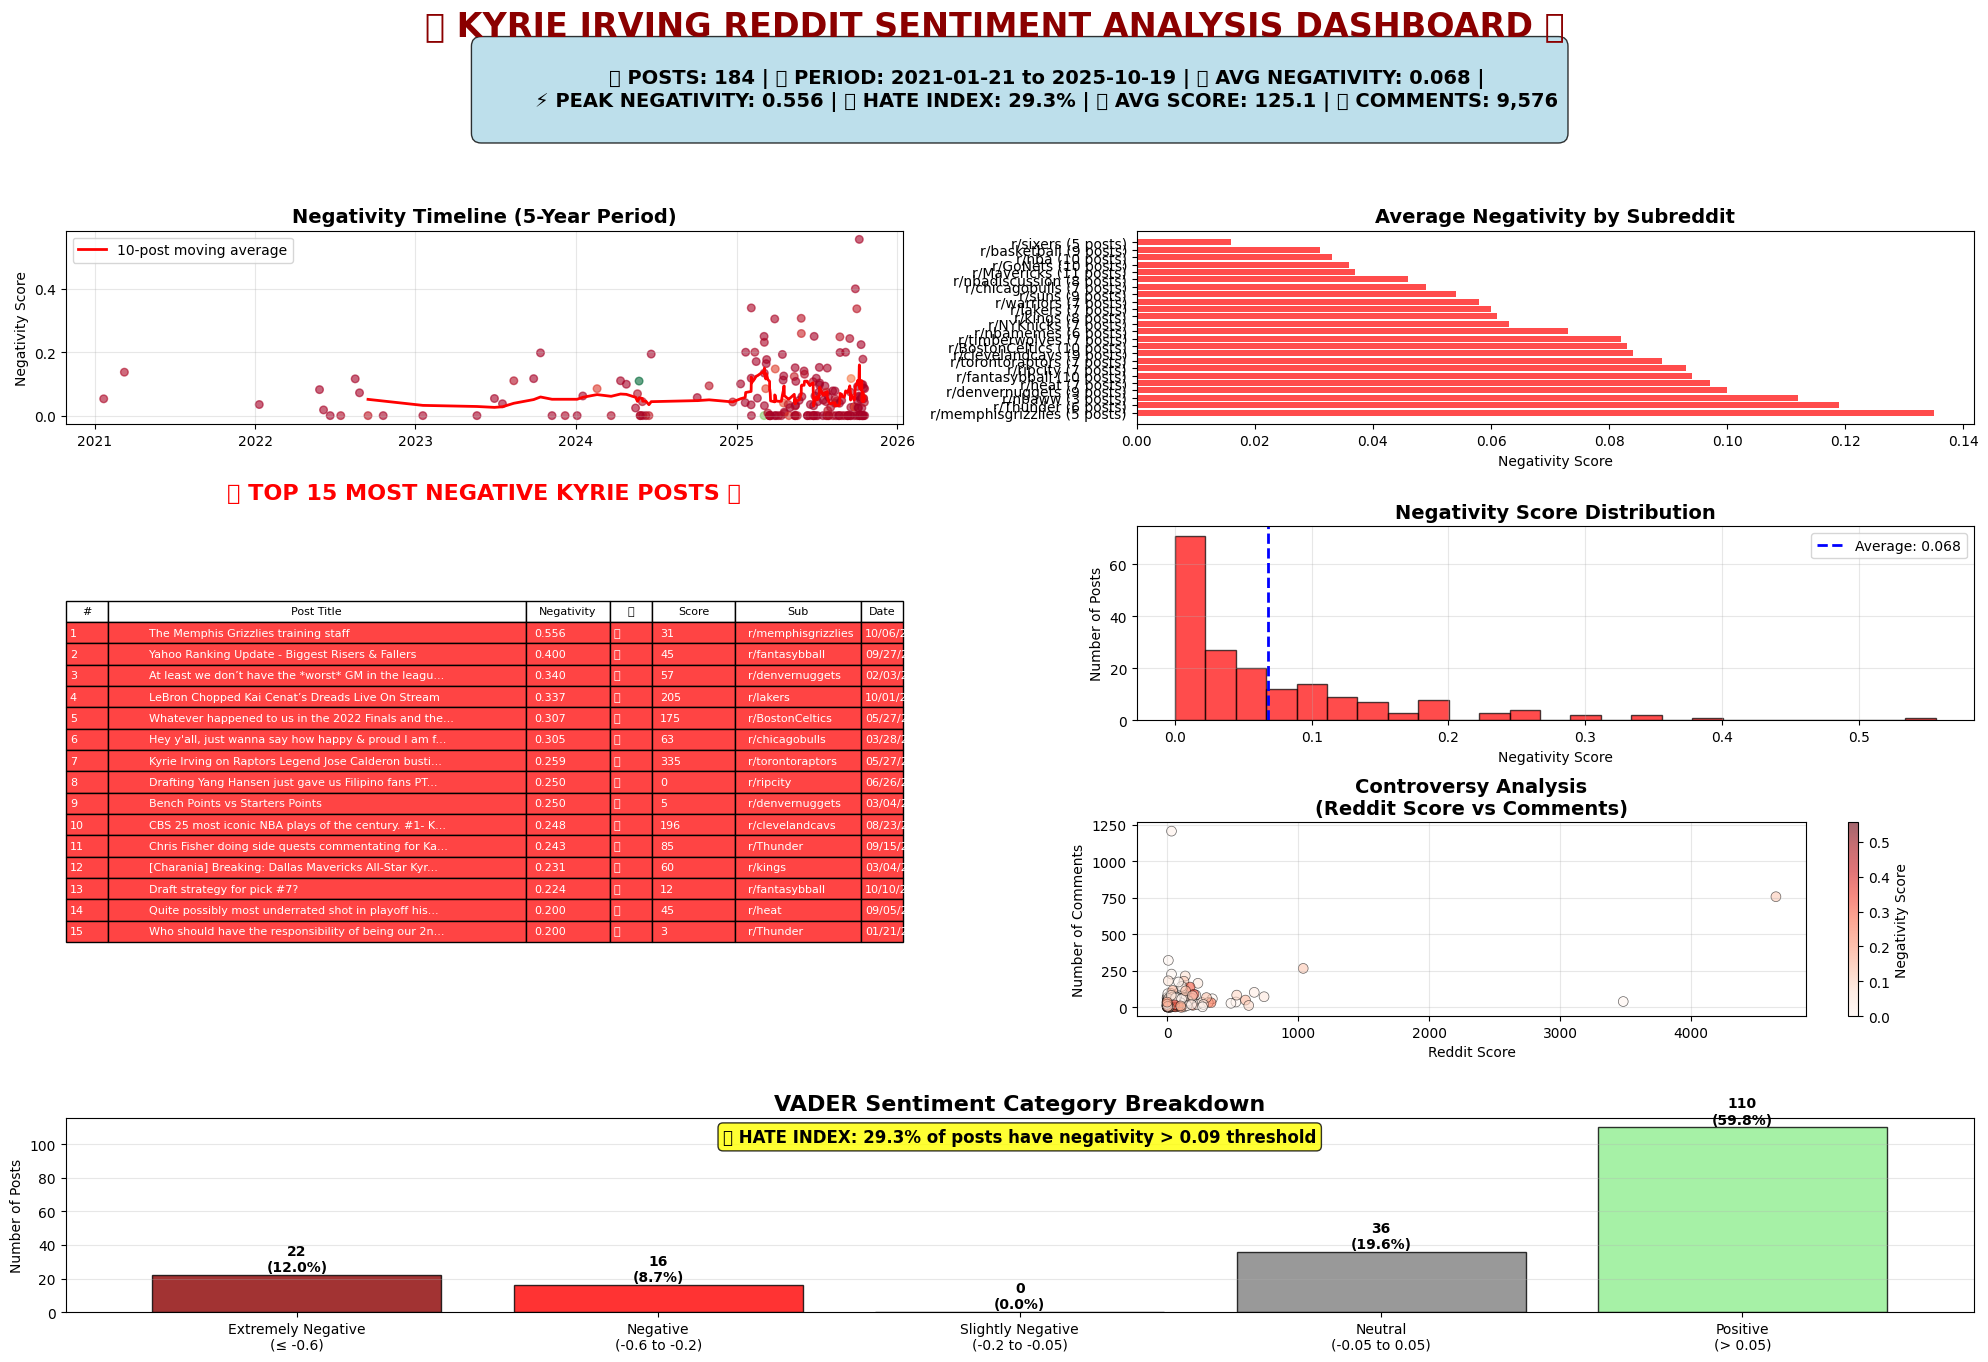

In [5]:
run_kyrie_irving_analysis()